# NWL Fire Emissions Blog Post
### Analysis of emissions due to fires and comparison with GHG reductions from other sectors
By Oriana Chegwidden - December 4, 2020

The NFED analysis code uses as its basis https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/code/get_GFED4s_CO_emissions.py

In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import regionmask

import numpy as np
import h5py
import fsspec
import pandas as pd
from tqdm import tqdm
C_TO_CO2_CONVERSION = 3.66

# Update this to where you're working!
work_dir = '/home/jovyan/blogposts/nwl-california-forests/analyses/'

In [8]:



months       = '01','02','03','04','05','06','07','08','09','10','11','12'
sources      = 'SAVA','BORF','TEMF','DEFO','PEAT','AGRI'


# in this example we will calculate annual CO emissions for the 14 GFED 
# basisregions over 1997-2014. Please adjust the code to calculate emissions
# for your own specie, region, and time period of interest. Please
# first download the GFED4.1s files and the GFED4_Emission_Factors.txt
# to your computer and adjust the directory where you placed them below

directory    = 'https://www.geo.vu.nl/~gwerf/GFED/GFED4'


"""
Read in emission factors
"""

start_year = 1997
end_year   = 2020
# Do you want to calculate emissions for each of the different
# regions or just use their pre-calculated sum?
partitioning = False 
gfeds_regions = False

"""
make table with summed DM emissions for each region, year, and source
"""
CO2_table = np.zeros((1, end_year - start_year + 1))


for year in tqdm(range(start_year, end_year+1)):
    if year < 2017:
        annual_file = directory+'/GFED4.1s_'+str(year)+'.hdf5'
    else:
        annual_file = directory+'/GFED4.1s_'+str(year)+'_beta.hdf5'
    with fsspec.open(annual_file).open() as filename:
        f = h5py.File(filename, 'r')
    
    
    if year == start_year: # these are time invariable    
        basis_regions = f['/ancill/basis_regions'][:]
        grid_area     = f['/ancill/grid_cell_area'][:]
        lat_values = f['/lat'][:,0]
        lon_values = f['/lon'][0,:]
    
    CO2_emissions = np.zeros((720, 1440))
    ds_CO2_list = []
    for month in range(12):
        try:
    #         # read in DM emissions
            string = '/emissions/'+months[month]+'/C'
            C_emissions = f[string][:]
            if partitioning:
                for source in range(6):
                    # read in the fractional contribution of each source
                    string = '/emissions/'+months[month]+'/partitioning/C_'+sources[source]
                    contribution = f[string][:]
                    # calculate CO emissions as the product of DM emissions (kg DM per 
                    # m2 per month), the fraction the specific source contributes to 
                    # this (unitless), and the emission factor (g CO per kg DM burned)
                    C_emisisons += C_emissions * contribution
            else:
                # calculate the total annual emisisons
                CO2_emissions += C_emissions * C_TO_CO2_CONVERSION # Conversion mass C to CO2
        except KeyError:
            print('TOO BAD! {} not available'.format(month))

    
    # fill table with total values for the globe (row 15) or basisregion (1-14)
    if gfeds_regions: 
        CO2_table = pd.DataFrame(np.zeros((15, end_year - start_year + 1)), 
                             index=pd.date_range(start_year, end_year + 1, freq='A')) # region, year
        for region in range(15):
            if region == 14:
                mask = np.ones((720, 1440))
            else:
                mask = basis_regions == (region + 1)            
            CO2_table[region, year-start_year] = np.sum(grid_area * mask * CO2_emissions)
    else:
        # mask by california instead
        ds_CO2 = xr.DataArray(data=CO2_emissions * grid_area,
                             dims=['lat', 'lon'],
                             coords={'lat': lat_values,
                                    'lon': lon_values})
        ds_CO2_list.append(ds_CO2)
        if year==start_year:
            mask = regionmask.defined_regions.natural_earth.us_states_50.mask(ds_CO2)
        
        CO2_table[0,year-start_year] = ds_CO2.where(mask == 4).sum()


CO2_df = pd.Series(CO2_table.squeeze() * 1e-12,
                    index=pd.date_range(str(start_year), str(end_year+1), freq='Y'))

100%|██████████| 24/24 [04:06<00:00, 10.25s/it]

TOO BAD! 10 not available
TOO BAD! 11 not available


In [9]:
def date_format(date):
    """
    Convert time label to the format of pandas line plot
    """
    return f'{date.year}'

Load in CARB GHG Emissions Inventory from https://ww3.arb.ca.gov/cc/inventory/pubs/reports/2000_2018/ghg_inventory_trends_00-18.pdf

In [22]:
ghg_california_emissions_carb = pd.read_excel('{}/2000_2018_ghg_inventory_trends_figures.xlsx'.format(work_dir))
ghg_california_emissions_carb = pd.Series(list(ghg_california_emissions_carb.loc[4].values[2:]), 
                                          index=pd.date_range('2000','2019',freq='Y'))

Initialize the dataframe with fires.

In [23]:
full_emissions_df = pd.DataFrame(CO2_df, columns=['Fire (GFED)'])

For now just assume the emissions for 2019 and 2020 are the same as 2018 (but will likely improve this assumption)

In [24]:
full_emissions_df['Anthropogenic GHG Inventory'] = ghg_california_emissions_carb

Then add in CARB's fire estimates from https://ww3.arb.ca.gov/cc/inventory/pubs/ghg_emissions_forest_management_webinar_slides.pdf

In [25]:
#full_emissions_df['Fires - CARB'] = 
carb_fire = pd.read_csv('{}/digitized_carb_fire_emissions.csv'.format(work_dir),
            header=None)
carb_fire = pd.Series(carb_fire[1].values, index=pd.date_range('2000', '2020', freq='Y'))
full_emissions_df['Fire (CARB)'] = carb_fire

Then load in the carbon stock info from NWL inventory

In [26]:
# Load in the ts of stocks (which is in units of MMT C)
# CARB definition for Forests and Other Natural Lands (FONL) includes dead organic matter (DOM)


carb_fonl_stocks = pd.read_csv('{}/carb_fonl_stocks.csv'.format(work_dir), header=None)
dates = ['2001-12-31', '2010-12-31', '2012-12-31', '2014-12-31']
index = pd.to_datetime(dates, format='%Y-%m-%S')
idx = pd.date_range('2002', '2014', freq='Y')

carb_fonl_stocks = pd.Series(carb_fonl_stocks[1].values, index=index) * C_TO_CO2_CONVERSION
# Interpolate to gapfill and then do delta to calculate the loss in stock in that year
# and turn it negative since we'll be treating lost stock to be an emission
carb_fonl_stock_emissions = -carb_fonl_stocks.resample('A').sum().replace({0:np.nan}).interpolate().diff()

We also have an estimate from Holland et al (2019) which says that forests sequestered (net) XX MMT over a ten year period. Let's assume that becomes a X.X MMT/year constant value for comparison's sake.

In [27]:
# full_emissions_df['Net (Holland et al 2019)'] = X.X

In [28]:
#full_emissions_df['CARB Stock Emisisons'] = carb_fonl_stock_emissions
# and then (just as a guess- this could be suspect) we can estimate "sequestration" by removing fire
# full_emissions_df['Sequestration (CARB)'] = full_emissions_df['Net (Holland et al 2019)'] - full_emissions_df['Fire (CARB)']

Let's first just write out a df with just the variables for the blog post we're considering right now. Jeremy will use this to make a nice set of initial figures.

In [29]:
full_emissions_df.to_csv('{}/emissions.csv'.format(work_dir))

Text(0, 0.5, 'CO2 Emissions [MMT]')

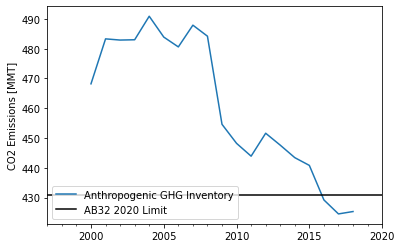

In [40]:
full_emissions_df[[
                'Anthropogenic GHG Inventory',
                  ]].plot()
plt.axhline(431, color='k', label='AB32 2020 Limit')
plt.legend()
plt.ylabel('CO2 Emissions [MMT]')

(0.0, 494.21999999999997)

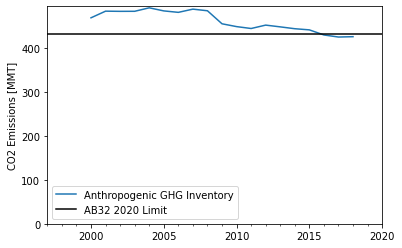

In [42]:
full_emissions_df[[
                'Anthropogenic GHG Inventory',
                  ]].plot()
plt.axhline(431, color='k', label='AB32 2020 Limit')
plt.ylabel('CO2 Emissions [MMT]')
plt.legend()
plt.ylim(0)

Text(0, 0.5, 'CO2 Emissions [MMT]')

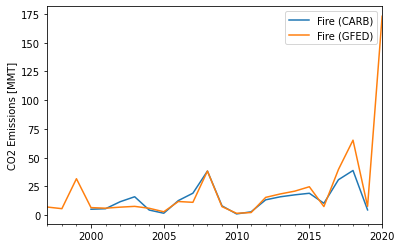

In [43]:
full_emissions_df[[
                'Fire (CARB)',
                'Fire (GFED)'
                  ]].plot()
plt.ylabel('CO2 Emissions [MMT]')